In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass
import asyncio
from concurrent.futures import ThreadPoolExecutor
import os
from groq import Groq
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import json
from langgraph.graph import Graph, StateGraph, END, START
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
import logging
from typing import Dict, Any
from langgraph.graph import StateGraph, MessagesState
from pydantic import BaseModel, Field
from datetime import date

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
load_dotenv()

True

In [3]:
llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [ ]:
# State definition
class BankReconciliationState(BaseModel):
    bank_data: str  # file path for bank data
    erp_data: str   # file path for ERP data
    bank_columns: Optional[dict] = None
    erp_columns: Optional[dict] = None

In [5]:
from pydantic import BaseModel, Field

class ColumnSchema(BaseModel):
    transaction_date: str = Field(..., description="Column name for transaction date")
    debit: str = Field(..., description="Column name for debit amount")
    credit: str = Field(..., description="Column name for credit amount")


In [6]:
structured_model_column = llm.with_structured_output(ColumnSchema)

In [7]:
# Reusable function for detecting columns
def detect_columns(file_path: str):
    df = pd.read_csv(file_path)
    subset_data = df.head(5)
    prompt = f"""
    From the following dataset, identify which column corresponds to:
    - transaction_date
    - debit
    - credit

    Dataset sample:
    {subset_data.to_dict(orient='records')}
    """
    return structured_model_column.invoke(prompt)


# Node: find columns in bank dataset
def find_bank_columns(state: BankReconciliationState):
    result = detect_columns(state.bank_data)
    return {"bank_columns": result}


# Node: find columns in ERP dataset
def find_erp_columns(state: BankReconciliationState):
    result = detect_columns(state.erp_data)
    return {"erp_columns": result}

In [ ]:
# Reusable function for detecting columns
def split_dateset(bank_file_path: str, erp_file_path: str):
    df = pd.read_csv(bank_file_path)
    subset_data = df.head(5)
    prompt = f"""
    From the following dataset, identify which column corresponds to:
    - transaction_date
    - debit
    - credit

    Dataset sample:
    {subset_data.to_dict(orient='records')}
    """
    return structured_model_column.invoke(prompt)

In [8]:
# Build workflow
graph = StateGraph(BankReconciliationState)

graph.add_node("find_bank_columns", find_bank_columns)
graph.add_node("find_erp_columns", find_erp_columns)

# Run them in parallel (both start from START)
graph.add_edge(START, "find_bank_columns")
graph.add_edge(START, "find_erp_columns")

# Both connect to END
graph.add_edge("find_bank_columns", END)
graph.add_edge("find_erp_columns", END)

# Compile workflow
workflow = graph.compile()


In [9]:
workflow

INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:56005/devtools/browser/4ca3aa21-f6d1-4ca3-9440-37d5f2fa06c8
INFO:pyppeteer.launcher:terminate chrome process...


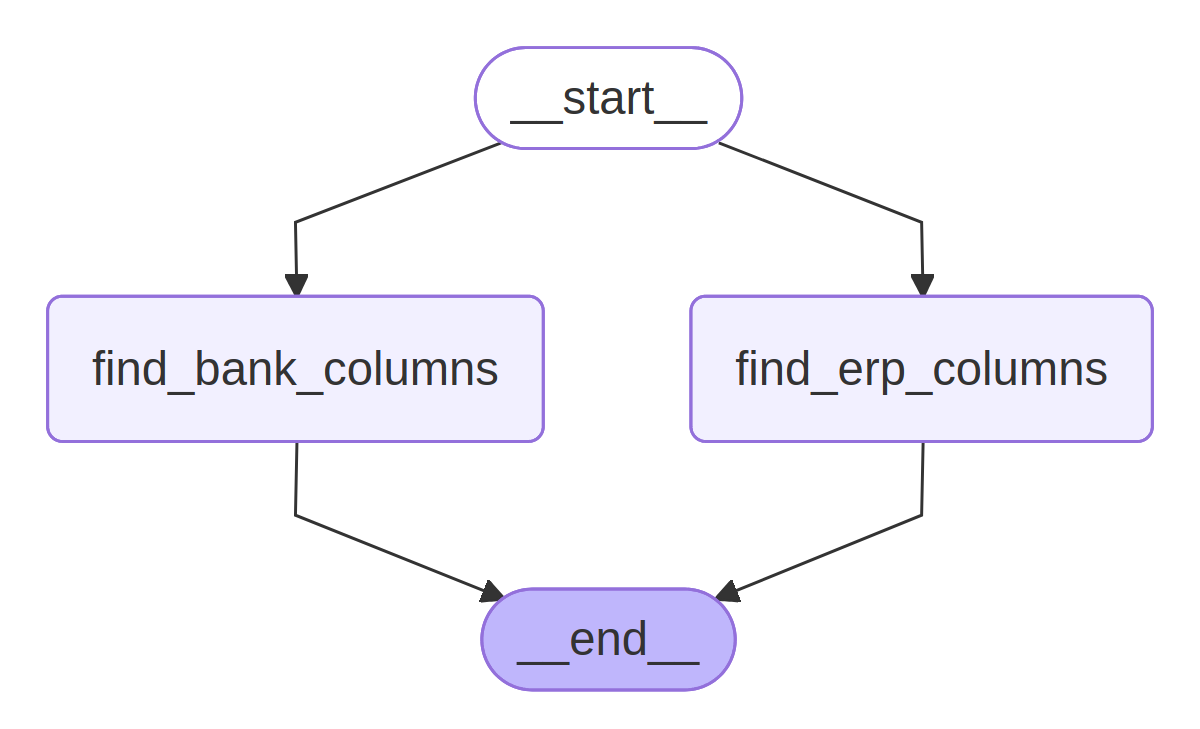

In [10]:
# from IPython.display import Image, display
# Image(workflow.get_graph().draw_mermaid_png())


import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

nest_asyncio.apply()  # patch the running event loop

# Render workflow graph locally
png = workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)
display(Image(png))


In [11]:
# Run with both datasets
initial_state = {
    "erp_data": "Dataset/Pubali # 41774-ERP.csv",
    "bank_data": "Dataset/Pubali # 41774.csv"
}
result = workflow.invoke(initial_state)

print("Bank Columns:", result["bank_columns"])
print("ERP Columns:", result["erp_columns"])

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Bank Columns: transaction_date='TRN DATE' debit='DEBIT' credit='CREDIT'
ERP Columns: transaction_date='Date' debit='Debit' credit='Credit'


In [12]:
bank_columns = result["bank_columns"]
erp_columns = result["erp_columns"]

In [13]:
# Option 1: Access each value individually
transaction_date = bank_columns.transaction_date
debit = bank_columns.debit
credit = bank_columns.credit

print(transaction_date, "\n", debit, "\n", credit)

TRN DATE 
 DEBIT 
 CREDIT


In [14]:
# Option 1: Access each value individually
transaction_date = erp_columns.transaction_date
debit = erp_columns.debit
credit = erp_columns.credit

print(transaction_date, "\n", debit, "\n", credit)

Date 
 Debit 
 Credit
